<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/UDOP/Layout_analysis_with_UDOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

Let's start by installing 🤗 Transformers, and Tesseract, which is the OCR engine we'll use.

In [1]:
!pip install --upgrade git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-gobfszqq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-gobfszqq
  Resolved https://github.com/huggingface/transformers.git to commit e5eb55b88b7200e81144eaf7a2bf3001b2bd08e7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!sudo apt install tesseract-ocr
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## Load model and processor

In [3]:
from transformers import UdopProcessor, UdopForConditionalGeneration

processor = UdopProcessor.from_pretrained("microsoft/udop-large-512")
model = UdopForConditionalGeneration.from_pretrained("microsoft/udop-large-512")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load image

Here we load a sample image from the PubLayNet dataset, a benchmark used for document layout analysis.

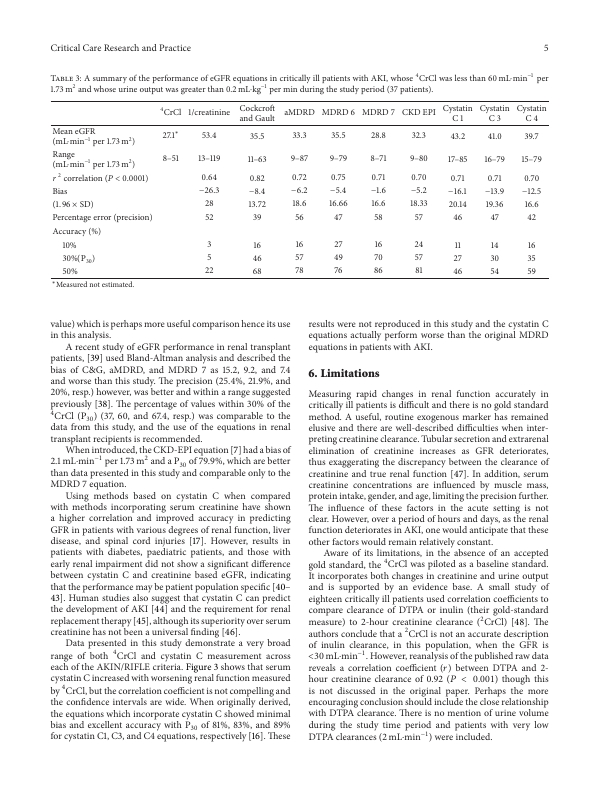

In [37]:
from huggingface_hub import hf_hub_download
from PIL import Image

filepath = hf_hub_download(
        repo_id="nielsr/dit-document-layout-analysis", filename="publaynet_example.jpeg", repo_type="space"
    )
image = Image.open(filepath).convert("RGB")
image

We can prepare it for the model using the processor. We can use the task prefix "Layout analysis. Element" to prompt the model (element can be replaced by one of the labels in PubLayNet such as "Title", "Paragraph", etc.)

In [53]:
prompt = "Layout analysis. Table"

encoding = processor(images=image.convert("RGB"), text=prompt, return_tensors="pt")
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([1, 1313])
attention_mask torch.Size([1, 1313])
bbox torch.Size([1, 1313, 4])
pixel_values torch.Size([1, 3, 512, 512])


In [54]:
processor.batch_decode(encoding.input_ids)

['Layout analysis. Table</s> ical Care Research and Practice 173m and howe urn outpost thin 2a prin da (comin per 172m") SBS BS (ctimin® perimim’y SS BIR e987 oration (P<unk> 0.000) vet oma (096% s0) = one Percentage ce (preion) a Accray (8) sour) as ‘alae which sperhaps moreuseful comparison hence suse in thicanalye ‘A recent study of GFR performance in en taneplant pallets, [39] used Mland-Allmananaljis and desrbed the bias of C&G, aMDRD. and MDRD 7 as 152, 92 and 24 nd worse than this study. The precision (25.4, 219%, and 20%, esp) however, was better and within aang suggested previously [8]. The percentage of values within 30% ofthe SCuct (Py) (37,60, and 62, esp) was comparable to the dst from this study, and the use of the equations in gel twanaplan recipients is ecommnended "When introduce, the CKD-EPL equation (7d abs of 2am per 73 and Py of 9.9%, which ste beter than data presented inthis study and comparable only to the MDRD? equation, ‘Using methods bated on eysatin C when c

## Generate

Next, the model autoregressively completes the prompt.

In [55]:
outputs = model.generate(**encoding)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1127: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Note that we don't want to skip special tokens here, as the model generates special location tokens.

In [57]:
output_text = processor.batch_decode(outputs, skip_special_tokens=False)[0]
print(output_text)

<pad> table<loc_42><loc_66><loc_456><loc_181></s>


## Visualize

Let's visualize the result! Note that we need to visualize this on the image as preprocessed by the processor. Hence we "denormalize" it for visualization purposes:

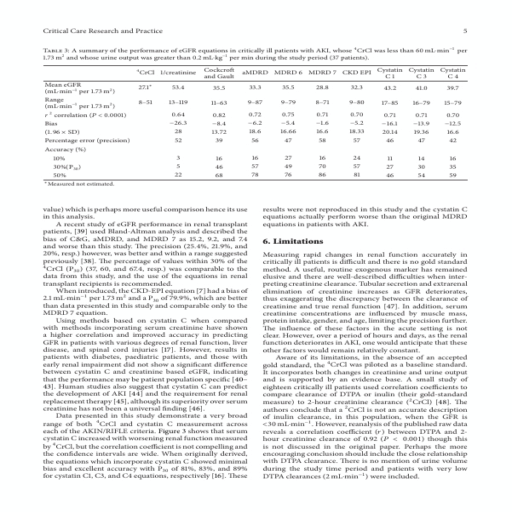

In [58]:
from PIL import Image
import numpy as np

mean = processor.image_processor.image_mean
std = processor.image_processor.image_std

unnormalized_image = (encoding.pixel_values.squeeze().numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = Image.fromarray(unnormalized_image)
unnormalized_image

In [59]:
import re

def extract_coordinates(string):
    # Using regular expression to find all numbers in the string
    numbers = re.findall(r'\d+', string)

    # Converting the numbers to integers
    numbers = list(map(int, numbers))

    # Ensuring there are exactly 4 numbers
    if len(numbers) != 4:
        numbers = numbers[-4:]

    # Extracting coordinates
    x1, y1, x2, y2 = numbers

    return [x1, y1, x2, y2]

# Example usage
coordinates = extract_coordinates(output_text)
print(coordinates)

[42, 66, 456, 181]


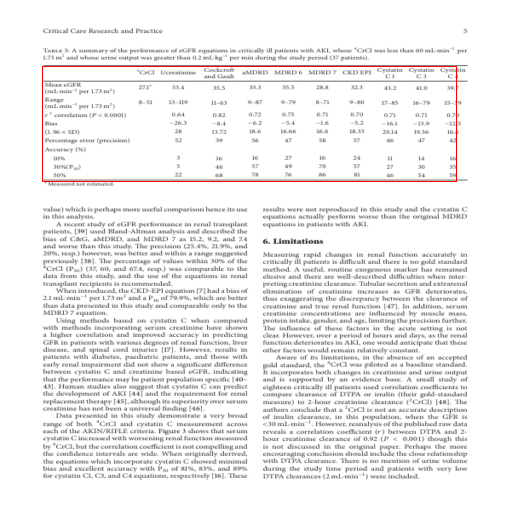

In [60]:
from PIL import ImageDraw

draw = ImageDraw.Draw(unnormalized_image)

draw.rectangle(coordinates, outline="red")
unnormalized_image

## Legacy

The code below was used for debugging purposes.

In [ ]:
from PIL import Image
import requests

url = "https://github.com/microsoft/i-Code/blob/main/i-Code-Doc/examples/00070353.png?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
from huggingface_hub import hf_hub_download
import torch

filepath = hf_hub_download(repo_id="nielsr/test-image", filename="input_ids_udop_512_layout_analysis.pt", repo_type="dataset")
input_ids = torch.load(filepath)

filepath = hf_hub_download(repo_id="nielsr/test-image", filename="seg_data_udop_512_layout_analysis.pt", repo_type="dataset")
bbox = torch.load(filepath)

filepath = hf_hub_download(repo_id="nielsr/test-image", filename="pixel_values_udop_512.pt", repo_type="dataset")
pixel_values = torch.load(filepath)